In [32]:
import argparse
import datetime
import glob
import importlib
import os
import shutil
import subprocess
import time
import dask.bag as db
import numpy as np
from matplotlib import pyplot as plt
from distributed import Client, wait
from dask.distributed import Client as dclient
from cmac import cmac, quicklooks, get_sounding_times, get_sounding_file_name, cmac_processing
import collections
import netCDF4
import pyart
import pickle

%matplotlib inline

In [2]:
def stupid_function(filename):
    print(filename)
    spath = '/ssd_data/sgp_soundings/'
    radar = pyart.io.read(filename)
    radar_start_date = netCDF4.num2date(radar.time['data'][0],
                                        radar.time['units'])
    sounding_times = get_sounding_times(spath)
    closest_time = min(sounding_times,
                       key=lambda d: abs(d - radar_start_date))
    sonde_file = get_sounding_file_name(spath,
                                        closest_time)
    sonde = netCDF4.Dataset(sonde_file)
    
    z_dict, temp_dict = pyart.retrieve.map_profile_to_gates(
        sonde.variables['tdry'][:], sonde.variables['alt'][:], radar)
    texture = cmac_processing.get_texture(radar)

    snr = pyart.retrieve.calculate_snr_from_reflectivity(radar)
    radar.add_field('sounding_temperature', temp_dict, replace_existing=True)
    radar.add_field('height', z_dict, replace_existing=True)
    radar.add_field('SNR', snr, replace_existing=True)
    radar.add_field('velocity_texture', texture, replace_existing=True)
    my_fuzz, _ = cmac_processing.do_my_fuzz(radar, tex_start=2.4,
                                            tex_end=2.7, verbose=True)
    radar.add_field('gate_id', my_fuzz, replace_existing=True)
    
    cat_dict = {}
    for pair_str in radar.fields['gate_id']['notes'].split(','):
        cat_dict.update(
            {int(pair_str.split(':')[0]):pair_str.split(':')[1]})
    
    
    
    unique, counts = np.unique(my_fuzz['data'], return_counts=True)
    col = dict(zip(unique, counts))
    
    coolcol = {}
    for kkey in col.keys():
        coolcol.update({cat_dict[kkey] : col[kkey]})
    
    print(filename, 'loaded')
    i1 = radar.sweep_start_ray_index['data'][0]
    i2 = radar.sweep_end_ray_index['data'][0]
    shp = (radar.nrays, radar.ngates, radar.nsweeps, 
          radar.time['units'], radar.time['data'][0],
          radar.elevation['data'][0:10].mean(),
          radar.fields['reflectivity']['data'].mean(),
          np.percentile(radar.fields['reflectivity']['data'].compressed(), 10),
          np.percentile(radar.fields['reflectivity']['data'].compressed(), 50),
          np.percentile(radar.fields['reflectivity']['data'].compressed(), 90),
          np.percentile(radar.fields['reflectivity']['data'].compressed(), 99),
          radar.elevation['data'][i1:i2].mean(),
          coolcol)
    del radar
    sonde.close()
    print(filename, 'done')
    return shp

In [3]:
fname = '/ssd_data/smaller_case_i4/sgpxsaprI4.00.20180317.001001.mnt.XSE180316230330.RAWCHYG.maint'
#tr = pyart.io.read(fname)

In [4]:
stupid_function(fname)

/ssd_data/smaller_case_i4/sgpxsaprI4.00.20180317.001001.mnt.XSE180316230330.RAWCHYG.maint
/ssd_data/sgp_soundings/sgpsondewnpnC1.b1.20180316.233000.cdf


/home/scollis/anaconda/envs/cmac_env/lib/python3.6/site-packages/pyart/util/sigmath.py:62: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt(-2 * np.log(norm)) * (half_width) / np.pi


##
## CMAC calculation using fuzzy logic:
##    Doing multi_trip


/home/scollis/anaconda/envs/cmac_env/lib/python3.6/site-packages/skfuzzy/membership/generatemf.py:401: RuntimeWarning: invalid value encountered in less_equal
  idx = np.nonzero(x <= b)[0]
/home/scollis/anaconda/envs/cmac_env/lib/python3.6/site-packages/skfuzzy/membership/generatemf.py:404: RuntimeWarning: invalid value encountered in greater_equal
  idx = np.nonzero(x >= c)[0]
/home/scollis/anaconda/envs/cmac_env/lib/python3.6/site-packages/skfuzzy/membership/generatemf.py:407: RuntimeWarning: invalid value encountered in less
  idx = np.nonzero(x < a)[0]
/home/scollis/anaconda/envs/cmac_env/lib/python3.6/site-packages/skfuzzy/membership/generatemf.py:410: RuntimeWarning: invalid value encountered in greater
  idx = np.nonzero(x > d)[0]


##    Doing rain
##    Doing snow
##    Doing no_scatter
##    Doing melting
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 6479, 6479, 6479]), array([291, 292, 293, ...,  19,  20,  21]))
##    Doing hard constraining multi_trip
##     (array([2520, 2520, 2520, ..., 6479, 6479, 6479]), array([ 852,  853,  854, ...,  998,  999, 1000]))
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 6479, 6479, 6479]), array([   0,    1,    2, ...,  998,  999, 1000]))
##    Doing hard constraining rain
##     (array([ 720,  720,  720, ..., 6479, 6479, 6479]), array([903, 904, 905, ..., 368, 369, 370]))
##    Doing hard constraining melting


/home/scollis/anaconda/envs/cmac_env/lib/python3.6/site-packages/cmac/cmac_processing.py:137: RuntimeWarning: invalid value encountered in greater_equal
  const_area = np.where(np.logical_and(fld_data >= lower,
/home/scollis/anaconda/envs/cmac_env/lib/python3.6/site-packages/cmac/cmac_processing.py:138: RuntimeWarning: invalid value encountered in less_equal
  fld_data <= upper))


##     (array([   0,    0,    0, ..., 6479, 6479, 6479]), array([  0,   1,   2, ..., 390, 391, 392]))
2
/ssd_data/smaller_case_i4/sgpxsaprI4.00.20180317.001001.mnt.XSE180316230330.RAWCHYG.maint loaded
/ssd_data/smaller_case_i4/sgpxsaprI4.00.20180317.001001.mnt.XSE180316230330.RAWCHYG.maint done


(6480,
 1001,
 18,
 'seconds since 2018-03-16T23:03:30Z',
 10.318999999999999,
 0.48889166,
 -4.6325153411724855,
 -13.680000305175781,
 -3.319999933242798,
 2.5799999237060547,
 4.710000038146973,
 0.48855498,
 {'multi_trip': 81588, 'rain': 985379, 'snow': 145012, 'no_scatter': 5274501})

In [37]:
ddir = '/ssd_data/xsapri4case/'

allf = os.listdir(ddir)
fqdn = [ddir + this for this in allf ]

In [38]:
client = dclient(scheduler_file='/ssd_data/poo.json')
n_cores = sum(client.ncores().values())
print('## Opened dask cluster with ' + str(n_cores) + ' cores')


## Opened dask cluster with 20 cores


In [39]:
the_function = lambda x: stupid_function(x)
future = client.map(stupid_function, fqdn)
my_data = client.gather(future)

In [41]:
my_data[0]

(6480,
 1001,
 18,
 'seconds since 2018-03-16T01:30:27Z',
 10.693,
 0.48889166,
 -4.6939086519540485,
 -14.510000228881836,
 -3.2300000190734863,
 2.690000057220459,
 4.880000114440918,
 0.48922822,
 {'multi_trip': 103012,
  'rain': 921027,
  'snow': 140344,
  'no_scatter': 5322024,
  'melting': 73})

In [42]:
timear_rand = np.array([netCDF4.num2date(th[4], units=th[3]) for th in my_data])
arrrg = timear_rand.argsort()
timear = timear_rand[arrrg]

In [43]:
nrays = np.array([th[0] for th in my_data])[arrrg]
ngates = np.array([th[1] for th in my_data])[arrrg]
nsweeps = np.array([th[2] for th in my_data])[arrrg]
lowang = np.array([th[5] for th in my_data])[arrrg]
p99 = np.array([th[10] for th in my_data])[arrrg]
alow = np.array([th[11] for th in my_data])[arrrg]
cattt = np.array([th[12] for th in my_data])[arrrg]




In [44]:
rain = []
for i in range(len(cattt)):
    if 'rain' in cattt[i].keys():
        rain.append(cattt[i]['rain'])
    else:
        rain.append(0)

second_trip = []
for i in range(len(cattt)):
    if 'multi_trip' in cattt[i].keys():
        second_trip.append(cattt[i]['multi_trip'])
    else:
        second_trip.append(0)

snow = []
for i in range(len(cattt)):
    if 'snow' in cattt[i].keys():
        snow.append(cattt[i]['snow'])
    else:
        snow.append(0)

Text(0,0.5,'99th percentile Z (dBZ)')

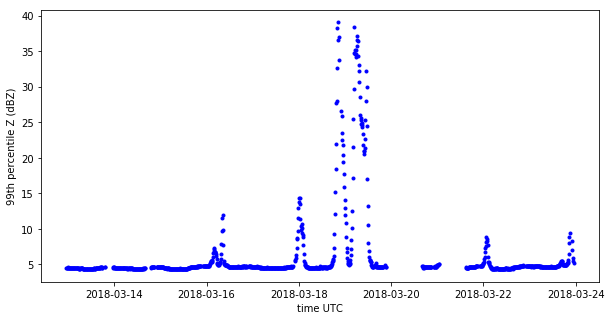

In [45]:
plt.figure(figsize=[10,5])
plt.plot(timear, p99, 'b.')

plt.xlabel('time UTC')
plt.ylabel('99th percentile Z (dBZ)')

Text(0.5,1,'i6 Elevation issues')

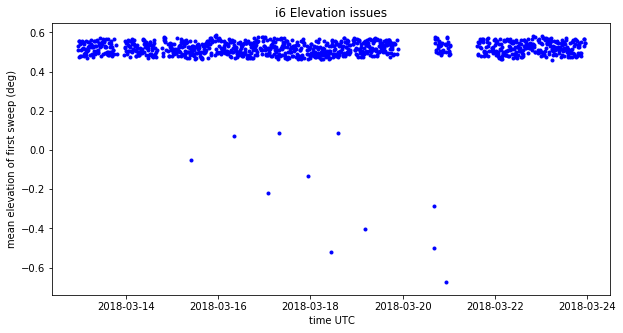

In [46]:
plt.figure(figsize=[10,5])
plt.plot(timear, alow, 'b.')
plt.xlabel('time UTC')
plt.ylabel('mean elevation of first sweep (deg)')
plt.title('i6 Elevation issues')

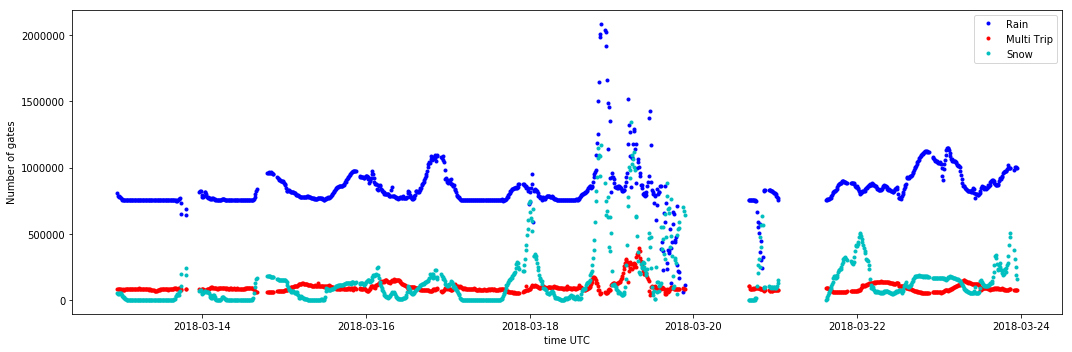

In [47]:
plt.figure(figsize=[15,5])
plt.plot(timear, rain, 'b.', label='Rain')
plt.plot(timear, second_trip, 'r.', label='Multi Trip')
plt.plot(timear, snow, 'c.', label='Snow')
plt.xlabel('time UTC')
plt.ylabel('Number of gates')
plt.legend()
plt.tight_layout()
plt.savefig('/home/scollis/arm_projects/phase_gf_devel/images/i4_gateid.png')

In [ ]:
np.unique(ngates)
print(len(np.where(ngates == 6476 )[0]))
print(len(np.where(ngates == 6480 )[0]))


In [40]:
pickle.dump( my_data, open( "/home/scollis/arm_projects/phase_gf_devel/data/i4_testing.pyk", "wb" ) )

In [ ]:
the_bag = db.from_sequence(fqdn)
the_function = lambda x: stupid_function(x)
result = the_bag.map(the_function).compute(num_workers=20)